# Expectation Maximization

The EM algorithm is a maximum likelihood estimation approach used in the presence of latent variables. This is done by first estimating the values for the latent variables and then optimizing the model. This is repeated until convergence. This two steps can be summarized as:
* E-Step: Estimate missing variables in the dataset.
* M-Step: Update the parameters of the model to maximize likelihood.

This notebook covers a practical implementation in Python of the EM algorithnm along with some examples.

## Unidimensional case with Gaussians
Suppose we have some data that we want to group into different clusters. 
We could consider a cluster to be a gaussian bell, following the normal distribution *N*($\mu$, $\sigma^{2}$). 

Each cluster would then be determined by two parameters: its mean $\mu$, and its variance $\sigma^{2}$. 
For each sample $s$ in the data, a probability  $\pi_{{s}_{i}}$ of belonging to the $i^{th}$ cluster could be considered. 


The goal is to find the means and variance of the different gaussians that could de used to cluster the data, while maximizing the likelihood.

#### Data generation
First, let's define a function to generate some data points to use as our dataset. This function receives the total number of samples to generate, the centers of mass of each of the different groups we want in our data and how spread we want samples in that group to be. 

In [1]:
import numpy as np

def generate_data(N, cm, spread):
    groups = min(len(cm), len(spread))
    data = []
    for i in range(groups):
        x = np.linspace(-spread[i] / 2, spread[i] / 2, num=int(N / groups))
        data.append(x * np.random.rand(len(x)) + cm[i])

    return np.concatenate(np.array(data)).flatten()

Now let's generate a dataset of a 90 samples, composed of 3 different groups. Each group of samples will have a different center of mass and a different spread. 

In [2]:
num_samples = 90
centers = (-5,2,13)
spreads = (5,1,8)

data = generate_data(num_samples,centers,spreads)

Let's visualize the data points.

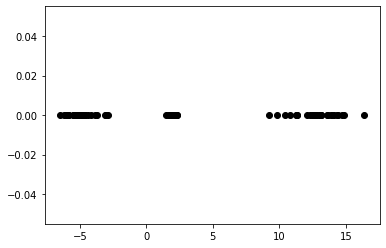

In [3]:
from matplotlib import pyplot as plt
plt.scatter(data, np.zeros(len(data)), c='k')
plt.show()

#### Probabilities visualized
Next, let's define how to evaluate the probability of a set of points belonging to a gaussian distribution with mean $\mu$ and std $\sigma$.

In [4]:
def eval(x, mu, sigma):
    _num = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    _den = sigma * ((2 * (np.pi) ** 2) ** 0.5)

    return _num / _den

Let's also define a function that plots these probabilities.

In [5]:
def plot(x, mus, sigmas, pis):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x, np.zeros(len(x)), c='k')

    for i in range(len(mus)):
        x_axis = np.linspace(mus[i] - 3 * sigmas[i], mus[i] + 3 * sigmas[i], len(x))
        ax.plot(x_axis, pis[i] * eval(x_axis, mus[i], sigmas[i]))
    plt.show()

We know the center of mass (mean) and spread (variance) of the dataset since we generated it. Ideally, we would like to get something like the following plot, which ilustrates 3 gaussians each centered at the mean of the groups and with the corresponding spread. The probability assigned to each cluster is 1/3, since our data generator creates the same number of samples per group.

Means:(-5, 2, 13). 
Stds :(1.118033988749895, 0.5, 1.4142135623730951)


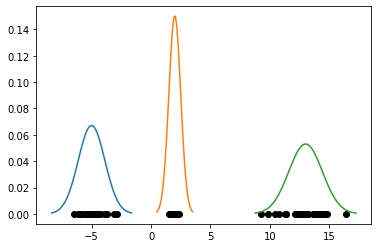

In [6]:
stds = tuple([(x**0.5)/2 for x in spreads])
print(f'Means:{centers}. \nStds :{stds}')
plot(data,centers,stds,(1/3,1/3,1/3))

#### Expectation Maximization 
Now let's define the EM algorithm. A few points to highlight are:
* The function expects the data points (dist), the number of Gaussians wished to use as clusters (K) and the maximum iterations allowed (iterations). 
* The initial $\sigma_{i}$ and $\mu_{i}$ are randomly selected. For example, the means for each cluster is a random integer between the maximum and minimum samples observed.
* Initially, the probability of samples belonging to a cluster assigned to each cluster is equally distributed.
* A maximum number of iterations is established in case convergence criterion is not met. This rarely happens, but could be so due to the initialization values of the parameters. 
* On each iteration the $\sigma$ and $\mu$ expected are printed.
* Upon convergence, a Gaussian with the last parameters is plotted.

In [7]:
def EM(dist, K, iterations):
    M = dist.shape[0]
    mus = np.random.randint(min(dist),max(dist),K)
    pis = np.ones(K) / K
    sigmas = np.random.rand(K) + 1

    ll_old = -np.inf

    for iter in range(iterations):
        print(f'Iteration: {iter}. Means: {mus}. Stds: {sigmas}')

        # E-step
        w = np.zeros((M, K))
        for k in range(K):
            w[:, k] = pis[k] * eval(dist, mus[k], sigmas[k])

        summed = w.sum(1)
        for m in range(M):
            w[m, :] /= summed[m]

        # M-step
        N_k = w.sum(0)
        pis = N_k / M

        mus = np.zeros(K)
        for k in range(K):
            for m in range(M):
                mus[k] += w[m, k] * dist[m]
        mus /= N_k

        sigmas = np.zeros(K)
        for k in range(K):
            for m in range(M):
                sigmas[k] += w[m, k] * (dist[m] - mus[k]) * (dist[m] - mus[k]).T
        sigmas /= N_k
        sigmas = sigmas ** 0.5

        # Convergence criterion
        ll_new = 0.0
        for k in range(K):
            ll_new += pis[k] * eval(dist, mus[k], sigmas[k])
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < 0.00000001:
            plot(dist, mus, sigmas, pis)
            break

        ll_old = ll_new

    return mus, sigmas, pis

Now it's time to run an experiment. We feed the algorithm with the data, the number of Gaussians we want to use and the maximum iterations. Keep the random seed fixed incase you want to get reproducible resutls.


Iteration: 0. Means: [-1  5  6]. Stds: [1.93255736 1.12812445 1.99904052]
Iteration: 1. Means: [-2.23540011  2.04655663 10.55462241]. Stds: [3.4095181  0.39274316 4.59342537]
Iteration: 2. Means: [-2.7721669   1.97923505 11.8155787 ]. Stds: [3.26372426 0.15797764 3.48712817]
Iteration: 3. Means: [-4.16353486  1.97824017 12.75254271]. Stds: [2.27324942 0.14416836 1.69160446]
Iteration: 4. Means: [-4.7693781   1.9710305  12.79884873]. Stds: [1.26960965 0.16447639 1.53844225]
Iteration: 5. Means: [-4.89578217  1.96460823 12.79884871]. Stds: [0.90317368 0.17240375 1.53844225]
Iteration: 6. Means: [-4.89579073  1.96460771 12.79884871]. Stds: [0.9031436  0.17240429 1.53844225]


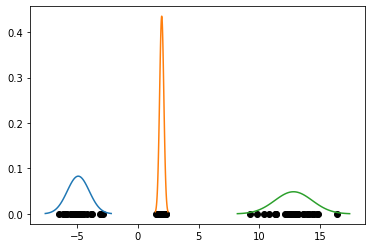

In [8]:
np.random.seed(1)
mus, sigmas, pis = EM(data, 3, 200)

The algorithm was able to cluster the 3 different groups present in the data. Let's try to reduce the number of gaussians to 2 and see what happens.

Iteration: 0. Means: [-1  5]. Stds: [1.72032449 1.00011437]
Iteration: 1. Means: [ 0.79286622 10.9172818 ]. Stds: [6.54990243 3.34926968]
Iteration: 2. Means: [ 0.19713969 12.61977142]. Stds: [5.6577156  2.23045388]
Iteration: 3. Means: [-0.67417782 12.94541772]. Stds: [4.63841982 1.44319091]
Iteration: 4. Means: [-1.13963289 12.95000352]. Stds: [3.95405035 1.41026246]
Iteration: 5. Means: [-1.32681143 12.87770861]. Stds: [3.68549296 1.46954404]
Iteration: 6. Means: [-1.4007573  12.83642442]. Stds: [3.58287254 1.50584829]
Iteration: 7. Means: [-1.42232826 12.82395568]. Stds: [3.55264973 1.51676964]
Iteration: 8. Means: [-1.42748316 12.82097314]. Stds: [3.54538828 1.5193671 ]
Iteration: 9. Means: [-1.42864082 12.82030353]. Stds: [3.5437552  1.51994927]
Iteration: 10. Means: [-1.42889694 12.8201554 ]. Stds: [3.54339379 1.520078  ]
Iteration: 11. Means: [-1.42895341 12.82012274]. Stds: [3.54331409 1.52010638]


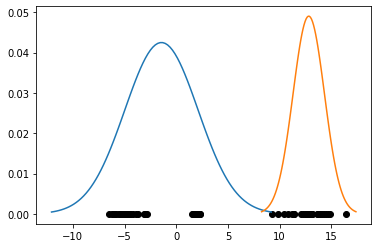

In [9]:
np.random.seed(1)
mus, sigmas, pis = EM(data, 2, 200)

Since we clustered the data with 2 gaussians now, the two closest groups got merged and classified into one.

Let's bring the groups closer to see how the algorithm performs. 

Do not keep the seed fixed, and re run this cell several times to see how the results change. Sometimes it takes more iterations to converge. Remember the algorithm might not converge due to inizialization, just re run the cell when finished.

Iteration: 0. Means: [-2  7  0]. Stds: [1.37980329 1.76292007 1.771595  ]
Iteration: 1. Means: [-1.82080277  6.96152195  1.07309409]. Stds: [1.05803027 1.66523711 1.66203592]
Iteration: 2. Means: [-2.04197617  7.1088076   1.42489287]. Stds: [0.59823215 1.50399339 1.47501905]
Iteration: 3. Means: [-2.08926719  7.1653378   1.7009021 ]. Stds: [0.49461455 1.42557958 1.13269852]
Iteration: 4. Means: [-2.06879971  7.13933465  1.79807834]. Stds: [0.50339359 1.42522766 0.81029457]
Iteration: 5. Means: [-2.02461955  7.10525348  1.85719672]. Stds: [0.54050226 1.44206773 0.5243019 ]
Iteration: 6. Means: [-1.96643293  7.10193117  1.92309894]. Stds: [0.61565846 1.44376213 0.33984427]
Iteration: 7. Means: [-1.89328796  7.1001891   1.97312768]. Stds: [0.72932963 1.44817223 0.1924589 ]
Iteration: 8. Means: [-1.88418501  7.10287735  1.97881273]. Stds: [0.74199254 1.44232544 0.16772589]
Iteration: 9. Means: [-1.88415379  7.10275689  1.97879341]. Stds: [0.74203766 1.44243848 0.16770333]


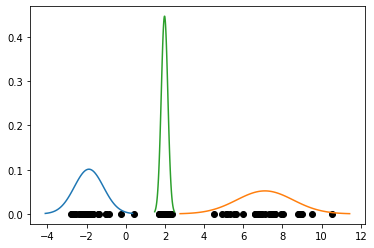

In [10]:
num_samples = 90
centers = (-2,2,7)
spreads = (5,1,8)

data = generate_data(num_samples,centers,spreads)
mus, sigmas, pis = EM(data, 3, 200)

#### Unabalanced groups
Let's re-define the data generator to produce unabalanced groups, that is, groups that have more samples than others.

In [11]:
def generate_data(N, cm, spread):
    groups = min(len(cm), len(spread), len(N))
    data = []
    for i in range(groups):
        x = np.linspace(-spread[i] / 2, spread[i] / 2, num=N[i])
        data.append(x * np.random.rand(len(x)) + cm[i])

    return np.concatenate(np.array(data)).flatten()

Now generate an unbalanced dataset and visualize it. Notice how the groups have differnet amount of samples

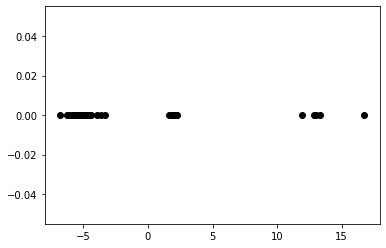

In [12]:
num_samples = (35,20,5)
centers = (-5,2,13)
spreads = (5,1,8)

data = generate_data(num_samples,centers,spreads)
plt.scatter(data, np.zeros(len(data)), c='k')
plt.show()

Use EM algorithm to find these clusters.

Iteration: 0. Means: [-1  5  6]. Stds: [1.93255736 1.12812445 1.99904052]
Iteration: 1. Means: [-3.21004689  2.03328197  7.59526303]. Stds: [3.16191945 0.13723621 5.89273524]
Iteration: 2. Means: [-4.02606821  2.01624935  9.58382245]. Stds: [2.57866857 0.12237405 6.41328231]
Iteration: 3. Means: [-4.88766009  1.99764022 12.02377628]. Stds: [1.30515426 0.13821751 4.77863982]
Iteration: 4. Means: [-5.06920723  1.98349601 13.42196396]. Stds: [0.70934285 0.15187523 2.11774731]
Iteration: 5. Means: [-5.0691668   1.98310486 13.56631226]. Stds: [0.70934546 0.15228669 1.66304623]


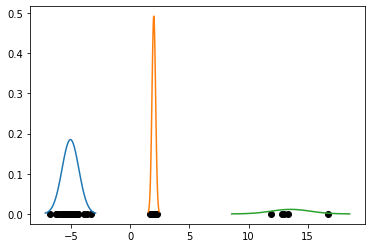

In [13]:
np.random.seed(1)
mus, sigmas, pis = EM(data, 3, 200)

Cluster using 2 gaussians.

Iteration: 0. Means: [-1  5]. Stds: [1.72032449 1.00011437]
Iteration: 1. Means: [-2.11596311  9.1084688 ]. Stds: [4.54227598 5.05099555]
Iteration: 2. Means: [-2.49410353 11.56508425]. Stds: [3.5884482  4.86477928]
Iteration: 3. Means: [-2.54128407 12.53117768]. Stds: [3.43413946 3.70046708]
Iteration: 4. Means: [-2.51032551 13.39073407]. Stds: [3.44029307 2.17527563]
Iteration: 5. Means: [-2.50413656 13.56682351]. Stds: [3.44171932 1.66321586]
Iteration: 6. Means: [-2.50416281 13.56683945]. Stds: [3.44166033 1.6631331 ]


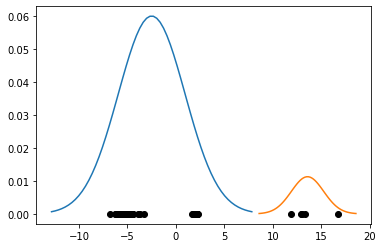

In [14]:
np.random.seed(1)
mus, sigmas, pis = EM(data, 2, 200)

As a last example, let's create an unbalanced dataset of 5 groups, whose centers of mass are not too separated.

Iteration: 0. Means: [ 0 -4  1  1 10]. Stds: [1.3013605  1.77273915 1.15292982 1.57863393 1.009008  ]
Iteration: 1. Means: [ 0.63949834 -4.74743948  1.9755868   3.63147449 11.76728246]. Stds: [1.99556008 0.98690515 0.9662139  2.26759397 2.70258213]
Iteration: 2. Means: [ 0.3399088  -4.77766925  1.97193828  4.09558833 12.00616538]. Stds: [2.20943897 0.91822565 0.36918494 2.36516684 2.60966006]
Iteration: 3. Means: [-0.58500569 -4.81424257  1.96985811  4.81864944 12.29858313]. Stds: [2.30067677 0.8730495  0.15324352 2.32813283 2.34599285]
Iteration: 4. Means: [-1.55519465 -4.84805389  1.97133889  5.56556963 12.60669537]. Stds: [1.81317922 0.83194146 0.14969215 1.86652725 2.00199439]
Iteration: 5. Means: [-2.02426315 -4.89665845  1.97036822  5.98423605 12.85677228]. Stds: [1.28360143 0.77518191 0.15302735 1.29172089 1.64517194]
Iteration: 6. Means: [-2.17629966 -4.95008724  1.96998797  6.10693648 12.93535896]. Stds: [1.03266447 0.7129915  0.15506709 1.06434822 1.51012356]
Iteration: 7. Me

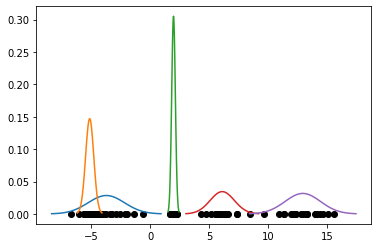

In [15]:
np.random.seed(1)
num_samples = (35,20,5,15,20)
centers = (-5,2,-2,6,13)
spreads = (5,1,4,7,8)

data = generate_data(num_samples,centers,spreads)
mus, sigmas, pis = EM(data, 5, 200)

It took EM 86 iterations to converge. The means found by EM (-5.14,-3.72,1.97,6.10,12.93) are not too far from the actual ones (-5,-2,2,6,13).